In [262]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
import matplotlib.ticker as mtick
from  itertools import product
import copy
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

### The objective of this project is to utilize Tensorflow to build a neural network that will predict NHL players' salary. Along the way I'll be exploring what metrics tend to drive a player's salary.

## Bringing the Data In

https://www.kaggle.com/camnugent/predict-nhl-player-salaries

I obtained here the salary info for 874 NHL players from the 2016-2017 season, along with 151 columns comprised of anything from  physical characteristics, shot statistcs (both individual and team while the player is on the ice), hit metrics, and so on.

*Side note: The salaries in the data are actual salaries the players recieve, not their cap hits.*

In [263]:
test_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary test.csv', encoding = 'ISO-8859-1')
train_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary train.csv', encoding = 'ISO-8859-1')
salaries = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\NHL salary test_salaries.csv', encoding = 'ISO-8859-1')

The data came already split between test and training data, but I'm going to stack them so I can clean and explore
the data at once, then split it on my own later on.

In [264]:
test_df['Salary'] = salaries['Salary']

df = train_df.append(test_df, sort = False)
df = df.reset_index()
df.drop('index', axis = 1, inplace = True)

df.head(n=5)

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


# Exploratory Data Analysis

This is definitely the longest section so I'll split it up into the following subsections:

1. Cleaning the Data
2. Identifying Columns with Missing Data
3. Bringing in DB2 Data Sets
4. Selecting the Top 100 Players
5. Joining DB1 and DB2
6. Dealing with the missing data in DB1
7. Bringing in Extra Features from DB2






## Cleaning the Data

**Getting age at the start of the season**

In [265]:
# Start of season is Oct 12, 2016
def elapsed_days(start, end=datetime(2016,10,12)):
    """ calcualte the number of days start and end dates"""
    x = (end - start)/365.25
    return x.days

# Get ages for season
df['AgeStart'] = df.apply(lambda x: elapsed_days(datetime.strptime(x['Born'], '%y-%m-%d')) ,axis=1)

**Dropping some columns**

In [266]:
# This player has a ton of missing info and only 1 game played
df = df[df['Last Name'] != 'Renouf']

# Drop columns that are of no use or redundant
# drop_cols = ['City', 'Pr/St', 'Cntry', 'Last Name', 'First Name', 'Team', 'Born']
drop_cols = ['City', 'Pr/St', 'Cntry']
drop_cols2 = ['Position', 'LastName', 'FirstName', 'Team']
# I'll drop name, position, and team later, but I'll keep them in for now to help with the EDA process
df.drop(drop_cols, axis = 1, inplace = True)


# Two average shot distance measures. Not sure what the difference is
# but one is non-numeric and has missing values so I dropeed it
df.drop('sDist.1', axis = 1, inplace = True)

*Just a note:*

*I'll drop the team and name fields later, as I don't believe they'll have any predictive value, but I'll keep them in for now to help with the EDA process*

**Changing some of the column names to prevent formatting issue with Keras**

In [267]:
# Tensorflor doesn't seem to like symbols in column names
df.columns = df.columns.str.replace('/', '')
df.columns = df.columns.str.replace('+', 'pls')
df.columns = df.columns.str.replace('-', 'min')
df.columns = df.columns.str.replace('%', 'perc')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace(' ', '')

**Parsing and pivoting a the Position field**

*Example: A player with a Position listed as "C/RW/LW" have a 1 for the newly created "C", "RW", and "LW" fields.*

In [268]:
# # Parse players with multiple positions and pivot
df['Position'] = df['Position'].apply(lambda x: x.split('/') if isinstance (x, str) else [x])
s = df['Position']
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=df.index)
df = df.join(dummies)


# Create lastname_first name field
df['last_first'] = df['LastName'] + '_' + df['FirstName']
drop_cols2.append('last_first')

## Identifying Columns with Missing Data

In [269]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(10)

,Total,Percent
Ovrl,124,0.142039
DftYr,124,0.142039
DftRd,124,0.142039
iCF,10,0.011455
iFF,10,0.011455
iRB,10,0.011455
iDS,10,0.011455
iHA,10,0.011455
iHDf,10,0.011455
iSF,10,0.011455


The missing values in the first three columns all indicate the player was undrafted, so I'll go ahead and fill that in then deal with the rest. We'll be considering these categorical variables.

In [270]:
draft = ['Ovrl', 'DftYr','DftRd']

for c in draft:
    df[c].fillna('Undrafted', inplace = True)
    df[c] = df[c].astype(str)

In [271]:
# Missing values
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(10)

,Total,Percent
iCF,10,0.011455
iFF,10,0.011455
iRB,10,0.011455
iDS,10,0.011455
iHA,10,0.011455
iHDf,10,0.011455
iSF,10,0.011455
PDO,1,0.001145
Pass,1,0.001145
GSG,1,0.001145


So now we have a final list of columns that have missing data. Let's take a quick look at the list of players with missing data.

In [272]:
df2 = df.copy()
df2.drop(['DftYr', 'DftRd', 'Ovrl'], axis = 1, inplace = True)
df3 = df2[df2.isnull().any(axis=1)]
df3.reset_index()

print('Players with missing data')
df3.head(n=5)

Players with missing data


,Salary,Born,Nat,Ht,Wt,Hand,LastName,FirstName,Position,Team,...,DAP,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first
20,5000000.0,94-03-09,CAN,73,215,L,Rielly,Morgan,[D],TOR,...,10.0,122.4,34.9,0.46,22,0,1,0,0,Rielly_Morgan
22,925000.0,96-05-01,SWE,72,190,R,Nylander,William,"[C, RW]",TOR,...,5.3,121.6,61.0,0.75,20,1,0,0,1,Nylander_William
25,925000.0,96-05-25,CZE,72,181,R,Pastrnak,David,"[RW, LW]",BOS,...,7.2,120.0,89.4,1.19,20,0,0,1,1,Pastrnak_David
114,925000.0,97-09-17,USA,75,216,L,Matthews,Auston,[C],TOR,...,16.2,122.4,77.9,0.95,19,1,0,0,0,Matthews_Auston
141,892500.0,91-12-01,USA,70,208,R,Acciari,Noel,[C],BOS,...,30.0,96.4,4.8,0.17,24,1,0,0,0,Acciari_Noel


**You might be saying "But wait a minute Pat, David Krecji was definitely born before 1990. And James van Riemsdyk was for sure born before 1993."**

I noticed that too, and you're absolutely right. Looking into it further, the birthday for every player that I spot checked in the original test data (before I stacked them) was off by exactly four years. I have no clue why, but I posted a discussion on the Kaggle page to bring it to people's attention. Having the wrong ages for as many as 262 players seems like a pretty big deal to me. Consider, for example, the significant dropoff in production from the ages of 31 to 35. On the flip-side, you'd typically expect a good deal more out of a palyer when he's 25 as opposed to when he's 21 and still finding his way in the league. Thus, I'll look elsewhere to solve this issue

I was already toying with the idea of finding an additional dataset to help fill in the missing records above. I found a dataset that should be of help, and it also happens to have a date of birth that seems more reliable (that is I haven't found any errors with some spot checking) than the one we have now. Bringing in some longer term performance metrics should hopefully add some stability to our predicted results as well. Three birds with one dataset!

Let's put a bookmark on these players with missing data for now. We'll bring in the new data and get back to it a bit later.

## Bringing in DB2 Data Sets

***IMPORTANT NOTE***

***From now on, I'll be referring to the data that I've already brought in from the salary data set as DB1 (for database 1) and all of the data that I'm about to bring in below as DB2. This is just for ease of reference.***


https://www.kaggle.com/martinellis/nhl-game-data

There's a bunch of fun data to work with here at various levels of granularity. Player info, game data, play by play statistics etc.

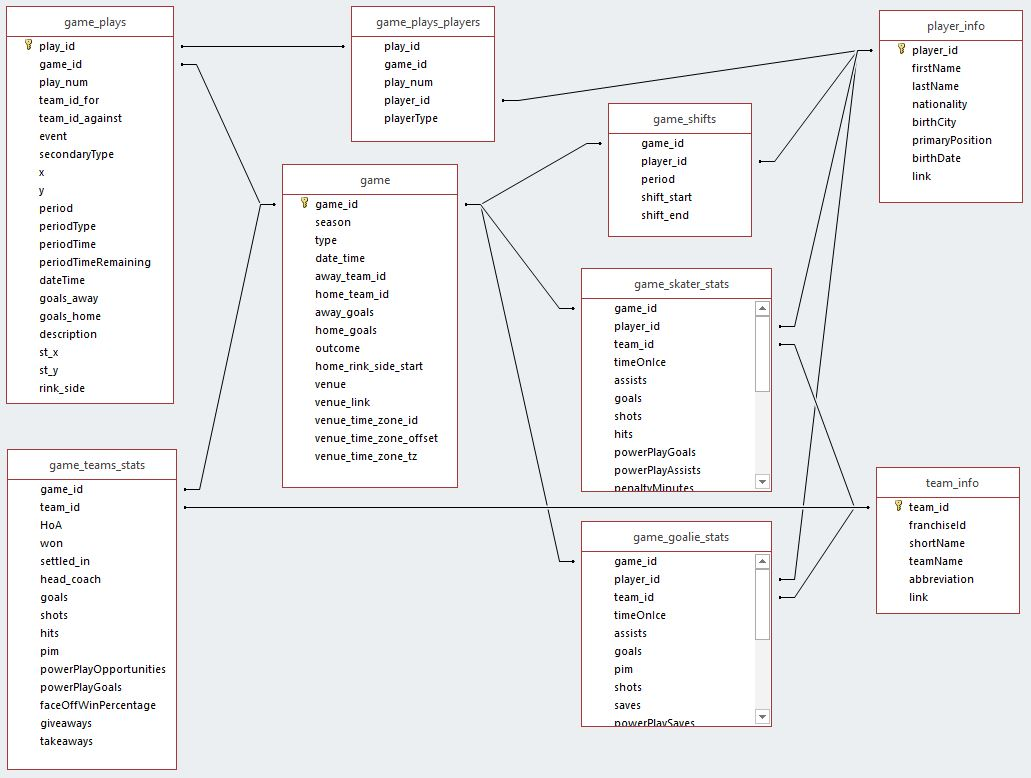

**Creating the Dataframes**

In [273]:
game0_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\game_skater_stats.csv')
player_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\player_info.csv')
game_info_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\game.csv')
player_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\player_info.csv')

game1_df = pd.merge(game_info_df[['game_id', 'season', 'type', 'date_time']], game0_df, on='game_id')
game2_df = pd.merge(player_df[['player_id', 'birthDate', 'firstName', 'lastName']], game1_df, on='player_id')

**Creating an age column for each game and the start of the season**

In [274]:
# Creating an Age column
game2_df['age'] = ((pd.to_datetime(game2_df['date_time']) - 
             pd.to_datetime(game2_df['birthDate'])).dt.days / 365.25).astype(float)

game2_df['age_rounded'] = ((pd.to_datetime(game2_df['date_time']) - 
             pd.to_datetime(game2_df['birthDate'])).dt.days / 365.25).astype(int)

min_age_df = game2_df.groupby(['season', 'player_id'], as_index=False)['age_rounded'].min().reset_index().rename(columns={'age_rounded':'age_start'})

**Converting time on ice to from seconds to minutes**

In [275]:
# Converting time on ice columns from seconds to minutes
game_df = pd.merge(min_age_df, game2_df, on=['player_id', 'season'])
game_df['timeOnIce'] = game_df['timeOnIce']/60
game_df['evenTimeOnIce'] = game_df['evenTimeOnIce']/60
game_df['shortHandedTimeOnIce'] = game_df['shortHandedTimeOnIce']/60
game_df['powerPlayTimeOnIce'] = game_df['powerPlayTimeOnIce']/60
agg_col = ['goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']
game_df['points'] = game_df['goals'] + game_df['assists']

**Aggregating the game statistcs by player + season, player, season, age and season, and by age.**

In [276]:
# Player by season
pseason_df = game_df[['player_id', 'firstName', 'lastName', 'age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName', 'season', 'age_start']).sum().reset_index()
# Player total
p_df = game_df[['player_id', 'firstName', 'lastName', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName']).sum().reset_index()
# By Season
season_df = game_df[['season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['season']).sum().reset_index()
# By age and season
age_season_df = game_df[['age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start', 'season']).sum().reset_index()
# By age
age_df = game_df[['age_start', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start']).sum().reset_index()

**Creating new fields for both goals and points per 60 minutes of playing time**

In [277]:
# Get goals + points per 60 for each df
pseason_df['goals_60'] = (pseason_df['goals'] / pseason_df['timeOnIce'])*60
pseason_df['points_60'] = (pseason_df['points'] / pseason_df['timeOnIce'])*60
p_df['goals_60'] = (p_df['goals'] / p_df['timeOnIce'])*60
p_df['points_60'] = (p_df['points'] / p_df['timeOnIce'])*60
season_df['goals_60'] = (season_df['goals'] / season_df['timeOnIce'])*60
season_df['points_60'] = (season_df['points'] / season_df['timeOnIce'])*60
age_df['goals_60'] = (age_df['goals'] / age_df['timeOnIce'])*60
age_df['points_60'] = (age_df['points'] / age_df['timeOnIce'])*60
age_season_df['goals_60'] = (age_season_df['goals'] / age_season_df['timeOnIce'])*60
age_season_df['points_60'] = (age_season_df['points'] / age_season_df['timeOnIce'])*60

## Selecting the Top 100 Players

**I'm going to isolate the top 100 players in points per 60 played (750 minutes of time on ice minimum). Looking at a more homogenous subset of players should be helpful in picking up on certain patterns.**

In [278]:
top100p_df = p_df.loc[p_df['timeOnIce'] > 750].sort_values(by=['points_60'], ascending=False).head(n=100)

top100_df = game_df.loc[game_df['player_id'].isin(top100p_df['player_id'])]

Now I'll split them up anc create the same new fields just like I did before.

In [279]:
# Player by season
pseason2_df = top100_df[['player_id', 'firstName', 'lastName', 'age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName', 'season', 'age_start']).sum().reset_index()
# Player total
p2_df = top100_df[['player_id', 'firstName', 'lastName', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['player_id', 'firstName', 'lastName']).sum().reset_index()
# By Season
season2_df = top100_df[['season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['season']).sum().reset_index()
# By age and season
age_season2_df = top100_df[['age_start', 'season', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start', 'season']).sum().reset_index()
# By age
age2_df = top100_df[['age_start', 'timeOnIce', 'points', 'goals', 'assists', 'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']].groupby(['age_start']).sum().reset_index()


# Get goals + points per 60 for each df
pseason2_df['goals_60'] = (pseason2_df['goals'] / pseason2_df['timeOnIce'])*60
pseason2_df['points_60'] = (pseason2_df['points'] / pseason2_df['timeOnIce'])*60
p2_df['goals_60'] = (p2_df['goals'] / p2_df['timeOnIce'])*60
p2_df['points_60'] = (p2_df['points'] / p2_df['timeOnIce'])*60
season2_df['goals_60'] = (season2_df['goals'] / season2_df['timeOnIce'])*60
season2_df['points_60'] = (season2_df['points'] / season2_df['timeOnIce'])*60
age2_df['goals_60'] = (age2_df['goals'] / age2_df['timeOnIce'])*60
age2_df['points_60'] = (age2_df['points'] / age2_df['timeOnIce'])*60
age_season2_df['goals_60'] = (age_season2_df['goals'] / age_season2_df['timeOnIce'])*60
age_season2_df['points_60'] = (age_season2_df['points'] / age_season2_df['timeOnIce'])*60

Now that we brought in and sliced and diced DB2 let's join it to DB1

## Joining DB1 and DB2

I want to bring in the player_id from DB2 into DB1. But first I'll create a concatenated LastName_FirstName field to join the tables on.

In [280]:
# Creating last name_first name field in DB2, then merging DB2 and DB1 by last_first to bring in player_id
player_df['last_first'] = player_df['lastName'] + '_' + player_df['firstName']
df = pd.merge(df, player_df[['player_id', 'last_first']], on='last_first', how = 'left')

Let's see if everybody was assigned a player_id.

In [281]:
# Check to see if every player in DB1 got a player_id from DB2
missing_names = df[df['player_id'].isnull()]
print('Number of players in DB1 that was not assigned a player_id')
print(len(missing_names))

Number of players in DB1 that was not assigned a player_id
27


**Not everyone got assigned a player_id when I merged DB1 and DB2. There could definitely be some players in DB1 but not DB2, but I'm also assuming that there might be a mismatch with regard to the spelling/abbreviation of a name.**

In [282]:
# Here I'm taking a look at where just the last names match up, in case one has Alex and the other Alexander etc.
mn = pd.merge(missing_names[['LastName', 'FirstName', 'last_first']], 
              player_df[['player_id', 'last_first', 'birthDate', 'lastName', 'firstName']], left_on='LastName', right_on = 'lastName', how = 'left')

print('It looks like my guess was right. Let\'s focus just on the players where naming convention is an issue and clean that up.')
mn.head(n=6)

It looks like my guess was right. Let's focus just on the players where naming convention is an issue and clean that up.


,LastName,FirstName,last_first_x,player_id,last_first_y,birthDate,lastName,firstName
0,Wennberg,Alex,Wennberg_Alex,8477505.0,Wennberg_Alexander,1994-09-22,Wennberg,Alexander
1,Nylander,Alex,Nylander_Alex,8477939.0,Nylander_William,1996-05-01,Nylander,William
2,Nylander,Alex,Nylander_Alex,8479423.0,Nylander_Alexander,1998-03-02,Nylander,Alexander
3,Tynan,T.J.,Tynan_T.J.,8476391.0,Tynan_TJ,1992-02-25,Tynan,TJ
4,Burrows,Alex,Burrows_Alex,8470358.0,Burrows_Alexandre,1981-04-11,Burrows,Alexandre
5,Mcquaid,Adam,Mcquaid_Adam,NaN,NaN,NaN,NaN,NaN


In [283]:
# Dropping players in DB2 but not DB1
mn = mn[mn['player_id'].notnull()]

# Removing players with the same last name but entirely different first name (different players entirely)
mn = mn[~mn['last_first_y'].isin(['Nylander_William', 'Carrier_William', 'Tanev_Brandon'])]

new_mn = mn[['LastName', 'FirstName', 'player_id', 'last_first_x']]

**Below you'll find all the players in DB2 that *do* exist in DB1 but had their first names enetered differently. With them you'll see their cleaned up last_first fields corresponding to their name in DB1.**

In [284]:
new_mn

,LastName,FirstName,player_id,last_first_x
0,Wennberg,Alex,8477505.0,Wennberg_Alex
2,Nylander,Alex,8479423.0,Nylander_Alex
3,Tynan,T.J.,8476391.0,Tynan_T.J.
4,Burrows,Alex,8470358.0,Burrows_Alex
6,Weegar,Mackenzie,8477346.0,Weegar_Mackenzie
8,Petrovic,Alex,8475755.0,Petrovic_Alex
9,O'Regan,Daniel,8476982.0,O'Regan_Daniel
12,Nieves,Cristoval,8476922.0,Nieves_Cristoval
13,Brodie,T.J.,8474673.0,Brodie_T.J.
14,Matheson,Michael,8476875.0,Matheson_Michael


Now we're going to bring in these player_id's into DB1 since they didn't come over in the initial merge.

In [285]:
for i in df['last_first']:
    if i in new_mn['last_first_x'].tolist():
        df.loc[df['last_first'] == i, 'player_id'] = float(new_mn.loc[new_mn['last_first_x'] == i, 'player_id'])

### Players in DB1 but not in DB2

In [286]:
missing_names2 = df[df['player_id'].isnull()]
# print('Now that we have the DB1-DB2 matching all cleaned up let\'s take a gander at the players in DB1 that aren\'t in DB2')
missing_names2

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,Pace,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id
127,3000000.0,86-10-12,CAN,76,212,2005.0,2.0,55.0,R,Mcquaid,...,111.3,25.4,0.33,30,0,1,0,0,Mcquaid_Adam,NaN
273,925000.0,92-09-06,USA,74,201,2012.0,6.0,181.0,R,Ladue,...,106.8,10.9,0.49,24,0,1,0,0,Ladue_Paul,NaN
327,925000.0,95-10-24,USA,71,183,2014.0,1.0,19.0,R,Deangelo,...,119.4,9.8,0.25,20,0,1,0,0,Deangelo_Anthony,NaN
333,575000.0,89-02-20,CAN,71,174,2007.0,6.0,164.0,R,Didomenico,...,107.2,0.8,0.26,27,1,0,0,1,Didomenico_Chris,NaN
560,925000.0,95-05-20,SWE,75,214,2013.0,2.0,34.0,L,De la Rose,...,99.7,-1.0,-0.11,21,0,0,1,0,De la Rose_Jacob,NaN
607,680000.0,93-04-16,USA,77,210,2011.0,4.0,101.0,L,Labate,...,107.1,-1.2,-0.09,23,1,0,0,0,Labate_Joseph,NaN
785,600000.0,97-05-02,CAN,73,195,2011.0,6.0,179.0,R,Demelo,...,109.5,9.2,0.37,19,0,1,0,0,Demelo_Dylan,NaN


**Check to make sure none of these players are missing data. That would make the data more difficult to fill in**

In [287]:
missing2 = pd.merge(missing_names2, df3, how = 'inner', on = 'LastName')
print('Good stuff. All of the players with missing information in DB1 are in DB2 (i.e. all of them have player_id\'s)')
print('This means we can use DB2 data to fill in the missing DB1 data quite easily')
missing2

Good stuff. All of the players with missing information in DB1 are in DB2 (i.e. all of them have player_id's)
This means we can use DB2 data to fill in the missing DB1 data quite easily


,Salary_x,Born_x,Nat_x,Ht_x,Wt_x,DftYr,DftRd,Ovrl,Hand_x,LastName,...,DAP_y,Pace_y,GS_y,GSG_y,AgeStart_y,C_y,D_y,LW_y,RW_y,last_first_y


A quick spot check showed all of the birthdays are correct except for Dylan Demelo, his is off by 4 years. We can fix that manually.

In [288]:
# Correcting Demelo's birthday
df.loc[df['last_first'] == 'Demelo_Dylan', 'Born'] = datetime(1993,5,1)
df.loc[df['last_first'] == 'Demelo_Dylan', 'Born']

785    1993-05-01 00:00:00
Name: Born, dtype: object

**Now we'll create new player_id's for them.**

In [289]:
# Creating new player_id's for those missing one
max_id = df['player_id'].max()

new_id = []

for i in range(len(missing_names2)):
    new_id.append(max_id + i + 1)
    
missing_names2['player_id'] = new_id

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Now I can bring in the birthdays from DB2 into DB1.

### Bringing in the Correct Birthdays from DB2

In [290]:
df = pd.merge(df, player_df[['birthDate', 'player_id']], how = 'left', on = 'player_id')

Here I'm bringing in the newly created player_id's and correct birthdays from missing_names2 (i.e. the players that weren't in DB2).

In [291]:
for i in df['last_first']:
    if i in missing_names2['last_first'].tolist():
        df.loc[df['last_first'] == i, 'player_id'] = float(missing_names2.loc[missing_names2['last_first'] == i, 'player_id'])
        df.loc[df['last_first'] == i, 'birthDate'] = missing_names2.loc[missing_names2['last_first'] == i, 'Born']   

# Check to make sure everyone has a birtday
df[df['birthDate'].isnull()]
# df[df['player_id'].isnull()]

,Salary,Born,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


Now that we have a correct date of birth field, I'll drop the incorrect Born field.

In [292]:
df.drop('Born', axis = 1, inplace = True)

# Re-do age_start
df['birthDate'] = pd.to_datetime(df['birthDate'])
df['AgeStart'] = df.apply(lambda x: elapsed_days(x['birthDate']), axis = 1)

## Dealing with the missing data in DB1

To start we'll see which columns are missing for each player.

In [293]:
missing = {}
for i in range(len(df3)):
    player = df3['last_first'].iloc[i]
    missing[player] = []
    [missing[player].append(col) for col in df3.columns if df3[col].isnull().iloc[i]]

print(missing)    

{'Rielly_Morgan': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Nylander_William': ['iHA', 'iHDf'], 'Pastrnak_David': ['iHA', 'iHDf'], 'Matthews_Auston': ['iHA', 'iHDf'], 'Acciari_Noel': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Sanford_Zach': ['GSG'], 'Goodrow_Barclay': ['IPPperc'], 'Nash_Riley': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Couture_Logan': ['Pass'], 'Miller_Colin': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS', 'iHA', 'iHDf'], 'Miller_Kevan': ['iHA', 'iHDf'], 'Gardiner_Jake': ['iHA', 'iHDf'], 'Bozak_Tyler': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Smith_Trevor': ['SHperc', 'PDO'], 'Moore_Dominic': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Zaitsev_Nikita': ['iHA', 'iHDf'], 'Marner_Mitchell': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Beleskey_Matt': ['iHA', 'iHDf'], 'Krejci_David': ['iHA', 'iHDf'], 'Carrick_Connor': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'van Riemsdyk_James': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS'], 'Hyman_Zach': ['iHA', 'iHDf'], 'Krug_Torey': ['iCF', 'iFF', 'iSF', 'iRB', 'iDS']}


**It looks like these stats would be tricky to calculate on the side. If the stat exists in DB2, I'll bring that in directly. If it doesn't, then the goal here is to substitute these missing values with those from a similar player. Here I categorized each of these missing stats and provided a proxy metric for which I will find a similar player.**

### Team Metrics

SHperc: The team's (not individual) shooting percentage when the player was on the ice

*Proxy field: Average SHpercs for team*


PDO: The team's shooting and save percentages added together, times a thousand

*Proxy field: Average PDO for team*

**Players: Smith_Trevor**

### Shot Metrics

iSF: Shots on goal taken by this individual

*Proxy: Can get directly from 'shots' field in pseason_df*


iCF: Shot attempts (Corsi, SAT) taken by this individual

*Proxy: iSF*


iFF: Unblocked shot attempts (Fenwick, USAT) taken by this individual

*Proxy: iSF*


iRB: Rebound shots taken by this individual

*Proxy: iSF*


iDS: Dangerous shots taken by this player, the sum of rebounds and shots off the rush

*Proxy: iSF*

**Players: Rielly_Morgan, Acciari_Noel, Nash_Riley, Miller_Colin, Bozak_Tyler, Moore_Dominic, Marner_Mitchell, Carrick_Connor, Riemsdyk_James, Krug_Torey**

### Hit Metrics

iHA: Hits taken by this individual

*Proxy: iHF (hits thrown)*


iHDf: The difference in hits thrown by this individual minus those taken

*Proxy: iHF (hits thrown)*

**Players: Nylander_William, Pastrnak_David, Matthews_Auston, Miller_Colin, Miller_Kevan, Gardiner_Jake, Zaitsev_Nikita, Beleskey_Matt, Krejci_David, Hyman_Zach**

### Other

IPPperc: Individual points percentage, which is on-ice goals for which this player had the goal or an assist

*Proxy: PTS/60 (points per 60 minutes)*


GSG: The player's average game score

*Proxy: PTS/60 (points per 60 minutes)*


Pass: An estimate of the player's setup passes (passes that result in a shot attempt)

*Proxy: PTS/60 (points per 60 minutes)*

**Players: Sanford_Zach, Goodrow_Barclay, Couture_Logan**

First we'll take care of Trevor Smith since he's a unique case. Since the stats are at the team-level, we'll take the team (which would be the Nasheville Predators) average.

In [294]:
team_fields = ['SHperc', 'PDO']
df.loc[df['last_first'] == 'Smith_Trevor', 'Team']

415    NSH
Name: Team, dtype: object

In [295]:
df.loc[df['last_first'] == 'Smith_Trevor', 'SHperc'] = df.loc[df['Team'] == 'NSH', 'SHperc'].mean()
df.loc[df['last_first'] == 'Smith_Trevor', 'PDO'] = df.loc[df['Team'] == 'NSH', 'PDO'].mean()

print(df.loc[df['last_first'] == 'Smith_Trevor', 'SHperc'])
print(df.loc[df['last_first'] == 'Smith_Trevor', 'PDO'])

415    7.831034
Name: SHperc, dtype: float64
415    985.793103
Name: PDO, dtype: float64


### Bringing in Shots Taken

Now we're going to look at the shot metrics. I'm going to bring in shots taken (iSF in DB1) since that can be done directly. I'll then use it as a proxy metric for finding similar players to fill in the rest.

For the players that do have shots taken in both DB1 and DB2, I'm going to make sure
that the shot amounts from the two datasets roughly match up before bringing
them in for the players missing them

In [296]:
pseason16_df = pseason_df.copy()
pseason16_df = pseason16_df[pseason16_df['season'] == 20162017]

dfc = df.copy()
dfc = pd.merge(dfc, pseason16_df[['shots', 'player_id']], how = 'left', on = 'player_id')
dfc['Shots_Diff'] = dfc['shots'] - dfc['iSF']

print('94 players have a difference in shots greater than 20 between the data sets. Eh, close enough.')
dfc[dfc['Shots_Diff'] > 20].head(n=5)

94 players have a difference in shots greater than 20 between the data sets. Eh, close enough.


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,AgeStart,C,D,LW,RW,last_first,player_id,birthDate,shots,Shots_Diff
1,2250000.0,CAN,74,207,2012.0,1.0,15.0,R,Ceci,Cody,...,22,0,1,0,0,Ceci_Cody,8476879.0,1993-12-21,166.0,23.0
16,590000.0,CAN,71,183,2011.0,7.0,209.0,L,Wilson,Scott,...,24,1,0,1,0,Wilson_Scott,8476293.0,1992-04-24,155.0,28.0
21,5250000.0,CAN,70,188,2010.0,1.0,14.0,L,Schwartz,Jaden,...,24,1,0,1,0,Schwartz_Jaden,8475768.0,1992-06-25,212.0,33.0
22,925000.0,SWE,72,190,2014.0,1.0,8.0,R,Nylander,William,...,20,1,0,0,1,Nylander_William,8477939.0,1996-05-01,228.0,24.0
36,4250000.0,CHE,73,201,2008.0,2.0,38.0,L,Josi,Roman,...,26,0,1,0,0,Josi_Roman,8474600.0,1990-06-01,293.0,75.0


**Bringing shots taken into DB1**

In [297]:
pseason16_df = pd.merge(df[['player_id', 'last_first']], pseason16_df, how = 'inner', on = 'player_id').reset_index()
shots_players = df[df['iSF'].isnull()]['last_first'].tolist()

for i in shots_players:
    df.loc[df['last_first'] == i, 'iSF'] = float(pseason16_df.loc[pseason16_df['last_first'] == i, 'shots'])

print('Check to make sure all the missing data is now completely filled in')
df[df['iSF'].isnull()]

Check to make sure all the missing data is now completely filled in


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


### Finding Similar Players

### Shots

In [298]:
shot_df = df[['last_first', 'iSF', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'iSF', ascending=False).reset_index()

for i in shots_players:
    j = int(str(shot_df.index[shot_df['last_first'] == i].item()))
    print('')
    print(i + ': ' + str(j))
    print(shot_df.iloc[j - 10 : j + 10, :])
    print('')


Rielly_Morgan: 81
    index          last_first    iSF  PTS  TOIGP     Position
71    595       Malkin_Evgeni  193.0   72  18.62      [C, RW]
72    726          Lee_Anders  191.0   52  15.58      [LW, C]
73    792     Zuccarello_Mats  189.0   59  18.83  [RW, C, LW]
74    838       O'Reilly_Ryan  189.0   55  21.47  [C, LW, RW]
75    605     Marleau_Patrick  189.0   46  17.18      [LW, C]
76    239       Palmieri_Kyle  189.0   53  17.35  [RW, C, LW]
77    224       Werenski_Zach  188.0   47  20.92          [D]
78    612      Parayko_Colton  188.0   35  21.20          [D]
79    658      Pearson_Tanner  187.0   44  16.32         [LW]
80    303   Gallagher_Brendan  187.0   29  15.10         [RW]
81     20       Rielly_Morgan  187.0   27  22.05          [D]
82    251   Niederreiter_Nino  186.0   57  15.07         [RW]
83    217         Kesler_Ryan  186.0   58  21.30      [C, RW]
84    314          Fowler_Cam  186.0   39  24.85          [D]
85    116  Ristolainen_Rasmus  186.0   45  26.47   

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  after removing the cwd from sys.path.


For each player with a missing shot metric, the exhibit above includes players within 10 positions above and below the player with regard to shots taken. I looked through the tables to choose the proxy players. To be frank I didn't put a lot of effort into it. I was looking at position played, TOI per game played, and utilized my general hockey knowledge when I could. This will be the process for the rest of the missing data as well. Below you'll see my selections.

**Selections**

In [299]:
shot_fields = ['iCF', 'iFF', 'iRB', 'iDS']
shot_rep = {}

shot_rep['Rielly_Morgan'] = 'Werenski_Zach'
shot_rep['Acciari_Noel'] = 'Coleman_Blake'
shot_rep['Nash_Riley'] = 'Konecny_Travis'
shot_rep['Miller_Colin'] = 'Scandella_Marco'
shot_rep['Bozak_Tyler'] = 'Horvat_Bo'
shot_rep['Moore_Dominic'] = 'Beauvillier_Anthony'
shot_rep['Marner_Mitchell'] = 'Gaudreau_Johnny'
shot_rep['Carrick_Connor'] = 'Johns_Stephen'
shot_rep['van Riemsdyk_James'] = 'Pacioretty_Max'
shot_rep['Krug_Torey'] = 'Klefbom_Oscar'

print('Players missing shot-related metrics and which fields they\'re missing.')
print('')
for i in shots_players:
    print(i)
    print(missing[i])

Players missing shot-related metrics and which fields they're missing.

Rielly_Morgan
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Acciari_Noel
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Nash_Riley
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Miller_Colin
['iCF', 'iFF', 'iSF', 'iRB', 'iDS', 'iHA', 'iHDf']
Bozak_Tyler
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Moore_Dominic
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Marner_Mitchell
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Carrick_Connor
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
van Riemsdyk_James
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']
Krug_Torey
['iCF', 'iFF', 'iSF', 'iRB', 'iDS']


Now I'll fill in those fields using the players chosen above and check real quick to make sure everyone now has data where they're supposed to.

**Bringing in the Data**

In [300]:
for i in shot_fields:
    for j in shots_players:
        k = shot_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])

print('Check to make sure all the missing data is now completely filled in')        
df[df['iRB'].isnull()]

Check to make sure all the missing data is now completely filled in


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


Now I'll do the exact same thing for the hit stats.

### Hits

In [301]:
hits_players = ['Nylander_William', 'Pastrnak_David', 'Matthews_Auston', 'Miller_Colin', 'Miller_Kevan', 'Gardiner_Jake', 'Zaitsev_Nikita', 'Beleskey_Matt', 'Krejci_David', 'Hyman_Zach']

hit_df = df[['last_first', 'iHF', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'iHF', ascending=False).reset_index()

for i in hits_players:
    j = int(str(hit_df.index[hit_df['last_first'] == i].item()))
    print('')
    print(i + ': ' + str(j))
    print(hit_df.iloc[j - 10 : j + 10, :])
    print('')


Nylander_William: 609
     index          last_first  iHF  PTS  TOIGP     Position
599    546   Filppula_Valtteri   26   42  17.40      [C, LW]
600    245       Stollery_Karl   26    3  16.92          [D]
601    382         Eichel_Jack   26   57  19.92          [C]
602    769      Gabriel_Kurtis   26    1   5.82         [RW]
603    344     Koekkoek_Slater   25    4  12.98          [D]
604    355        Redmond_Zach   25    5  12.32          [D]
605    387       Winnik_Daniel   25   25  12.92      [LW, C]
606    417   Zolnierczyk_Harry   25    4   8.87         [LW]
607     47     Marincin_Martin   25    7  18.05          [D]
608    452  Liles_John-Michael   25    5  16.22          [D]
609     22    Nylander_William   25   61  15.92      [C, RW]
610    761      Enstrom_Tobias   24   14  21.90          [D]
611    299        Keith_Duncan   24   53  25.62          [D]
612    698        Russo_Robbie   24    0  16.07          [D]
613    773       Sharp_Patrick   24   18  15.95  [LW, RW, C]
6

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


**Selections**

In [302]:
hits_fields = ['iHA', 'iHDf']
hit_rep = {}

hit_rep['Nylander_William'] = 'Saad_Brandon'
hit_rep['Pastrnak_David'] = 'Zucker_Jason'
hit_rep['Matthews_Auston'] = 'Stamkos_Steven'
hit_rep['Miller_Colin'] = 'Nesterov_Nikita'
hit_rep['Miller_Kevan'] = 'Manning_Brandon'
hit_rep['Gardiner_Jake'] = 'Matheson_Michael'
hit_rep['Zaitsev_Nikita'] = 'Forbort_Derek'
hit_rep['Beleskey_Matt'] = 'Jaskin_Dmitrij'
hit_rep['Krejci_David'] = 'Hayes_Kevin'
hit_rep['Hyman_Zach'] = 'Ryan_Bobby'

**Bringing in the Data**

In [303]:
for i in hits_fields:
    for j in hits_players:
        k = hit_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])
        
print('Check to make sure all the missing data is now completely filled in')        
df[df['iHA'].isnull()]

Check to make sure all the missing data is now completely filled in


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


And now for the rest of the missing stats.

### Other

In [304]:
other_players = ['Sanford_Zach', 'Goodrow_Barclay', 'Couture_Logan']

other_df = df.copy()
other_df['PTS60'] = (other_df['PTS']/other_df['TOI'])*60*60
other_df = other_df[['last_first', 'PTS60', 'PTS', 'TOIGP', 'Position']].sort_values(by = 'PTS60', ascending=False).reset_index()

for i in other_players:
    j = int(str(other_df.index[other_df['last_first'] == i].item()))
    print('')
    print(i + ': ' + str(j))
#     print(j)
    print(other_df.iloc[j - 10 : j + 10, :])
    print('')


Sanford_Zach: 453
     index         last_first     PTS60  PTS  TOIGP     Position
443    694    Duclair_Anthony  1.166760   15  13.30     [LW, RW]
444    433    Beaulieu_Nathan  1.165453   28  19.48          [D]
445    648       Fedun_Taylor  1.164026    7  13.37          [D]
446    823      Brodziak_Kyle  1.163944   15  11.20          [C]
447     29       Schaller_Tim  1.160328   14  12.27          [C]
448    380       Gaudet_Tyler  1.154957    1  12.98          [C]
449    508     Severson_Damon  1.142377   31  20.32          [D]
450    813          Fehr_Eric  1.139536   11  10.93      [C, RW]
451    608         Shore_Nick  1.139410   17  12.78          [C]
452    805       Malgin_Denis  1.135933   10  11.23          [C]
453    178       Sanford_Zach  1.135199    8  10.85         [LW]
454    825   Goldobin_Nikolay  1.130772    3  11.37     [RW, LW]
455    730     Goligoski_Alex  1.129117   36  23.33          [D]
456    527       Brodin_Jonas  1.127283   25  19.55          [D]
457   

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


**Selections**

In [305]:
other_fields = ['IPPperc', 'GSG', 'Pass']
other_rep = {}

other_rep['Sanford_Zach'] = 'Malgin_Denis'
other_rep['Goodrow_Barclay'] = 'Scherbak_Nikita'
other_rep['Couture_Logan'] = 'Monahan_Sean'

**Bringing in the Data**

In [306]:
for i in other_fields:
    for j in other_players:
        k = other_rep[j]
        df.loc[df['last_first'] == j, i] = float(df.loc[df['last_first'] == k, i])
        
print('Check to make sure all the missing data is now completely filled in')        
df[df['IPPperc'].isnull()]

Check to make sure all the missing data is now completely filled in


,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,GS,GSG,AgeStart,C,D,LW,RW,last_first,player_id,birthDate


In [307]:
# Missing values
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'], sort=False)
missing_data.head(5)

,Total,Percent
birthDate,0,0.0
Pass,0,0.0
iTKA,0,0.0
iGVA,0,0.0
iMiss,0,0.0


**Looking good! Now that we've dealt with all of the missing data, we're ready to look into what extra features we want to bring in. I'm going to bring in every stat in DB2 that also exists in DB1, that way for the 7 players in DB1 but not DB2 I can just use the single-season stats I have for them in place of the longer-term stats being brought in.**

## Bringing in Extra Features from DB2

Here's a list of the fields that exist in both DB's. They keys (on the left) are from DB2 and the elements from DB1
Note that I'll have to add iFOW and iFOL from DB1

In [308]:
db12 = {'assists' : 'A', 'blocked' : 'iBLK', 'faceoffTaken' : 'iFOW + iFOL', 'faceOffWins' : 'iFOW',
        'giveaways' : 'iGVA', 'goals' : 'G', 'hits' : 'iHF', 'penaltyMinutes' : 'PIM', 'plusMinus' : 'plsmin',
        'shots' : 'iSF', 'takeaways' : 'iTKA', 'timeOnIce' : 'TOI'}

I'm also going to add in points per 60 minutes played into DB1 (I already added it to DB2).
This should be useful for the visualization process.

In [309]:
df['PTS60_16_17'] = (df['PTS']/df['TOI'])*60*60
db12['points_60'] = 'PTS60_16_17'

db2_fields = list(db12.keys())
db2_fields.append('player_id')
db2_fields
df = pd.merge(df, p_df[db2_fields], how = 'left', on = 'player_id')

Since I'll have to bring in two fields for faceoffTaken I'll add that in first first, remove it from the dictionary, then deal with the rest.

In [310]:
df['faceoffTaken'] = np.where(df['faceoffTaken'].isnull(), df['iFOW'] + df['FOL'], df['faceoffTaken'])
del db12['faceoffTaken']

Replacing all of the missing DB2 data with the corresponding DB1 data

In [311]:
for i in db12.items():
    c2 = i[0]
    df[i[0]] = np.where(df[i[0]].isnull(), df[i[1]], df[i[0]])

# Visualizations

OK, now we have all the fields we need. Time to start looking at the data a little

Below you'll see the spread of NHL salary contracts for the 2016-2017 season. The upper-end players make over \\$10 million (Connor McDavis currently makes the most in the league with a salary cap hit of $12.5m), entry-level contracts max out at \\$925k for either 1, 2, or 3 years depending on the players age, and most everyone else falls somewhere in between. This is just me shooting from the hip a tad, but here's my breakdown of general buckets players fall into and salaries you'd expect...

\>\\$10m - Elite players

\\$7-10m - Great players

\\$4-7m - Really good players

<\\$4m - Good/Serviceable players

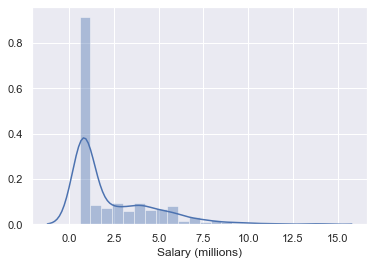

In [312]:
sns.distplot(df['Salary']/1000000, axlabel = 'Salary (millions)')

Now let's look at how Salary relates to a few different statistics.

### Points

Offensive production is no doubt a strong consideration here, let's look at point production for the 16-17 season.

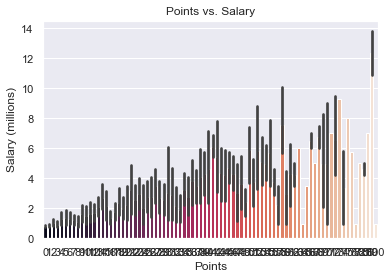

In [313]:
fig = sns.barplot(x='PTS', y=df['Salary']/1000000, data = df, palette='rocket')
plt.xlabel('Points')
plt.ylabel('Salary (millions)')
plt.title('Points vs. Salary')
plt.show(fig)

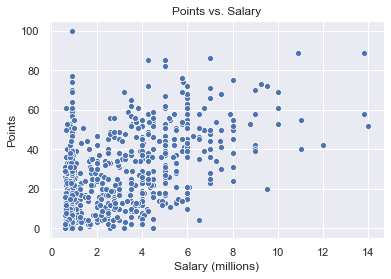

In [314]:
fig = sns.scatterplot(x = df['Salary']/1000000, y = 'PTS', data = df)
plt.xlabel('Salary (millions)')
plt.ylabel('Points')
plt.title('Points vs. Salary')
plt.show(fig)

No surprise here, you can see a pretty clear upward trend. Now as I noted earlier, a player in his first few years in the league will be making the NHL Entry Level Contract amount of \\$925k no matter how talented. Right away you'll see that 100 point mark in the top left, that would be Connor McDavid with his league-leading 100 point sophomore season. I'd be willing to wager most of the palyers putting up over 40-50 points in that column are similarly in their entry level contracts. There's a lot of good young talent in the league nowadays, so this isn't unusual. They'll be making the big bucks in a couple years.

A couple notes. There is far more that goes into what a player is worth than points scored. Play away from the puck is just as importatant as with the puck. As they say, defense wins championships. Then there's grit, leadership, character and all those other intangibles GMs love in a player. It's also import to note the difference between how much a player IS making compared to what they SHOULD be making, even exluding ELCs you'll find many players in the league that are either overpaid or underpaid.

Here's a list of players who scored over 50 points while making less than a million. All of them should be on their ELC, and most, if not all, are making considerably more money these days. Whether or not to include players on their ELC is something worth considering, depending on whether it distorts the predictions. I'll look into this a little later.

In [315]:
df[(df['Salary'] < 1000000) & (df['PTS'] > 50)]

,Salary,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,LastName,FirstName,...,faceOffWins,giveaways,goals,hits,penaltyMinutes,plusMinus,shots,takeaways,timeOnIce,points_60
22,925000.0,SWE,72,190,2014.0,1.0,8.0,R,Nylander,William,...,796.0,132.0,58.0,85.0,66.0,16.0,610.0,190.0,4194.516667,2.474659
25,925000.0,CZE,72,181,2014.0,1.0,25.0,R,Pastrnak,David,...,13.0,355.0,149.0,317.0,149.0,45.0,1080.0,222.0,6192.833333,3.168178
45,925000.0,SWE,74,196,2013.0,1.0,14.0,L,Wennberg,Alex,...,2043.0,110.0,36.0,220.0,71.0,6.0,443.0,189.0,6145.850000,1.776809
114,925000.0,USA,75,216,2016.0,1.0,1.0,L,Matthews,Auston,...,1512.0,180.0,121.0,99.0,40.0,13.0,792.0,210.0,4214.566667,3.103522
316,832500.0,CAN,71,188,2013.0,1.0,3.0,L,Drouin,Jonathan,...,606.0,218.0,65.0,278.0,126.0,-52.0,679.0,208.0,5598.816667,2.229042
382,925000.0,USA,74,196,2015.0,1.0,2.0,R,Eichel,Jack,...,1656.0,232.0,101.0,191.0,102.0,-65.0,1036.0,157.0,5687.566667,2.732276
393,832500.0,CAN,72,223,2013.0,1.0,9.0,L,Horvat,Bo,...,3786.0,120.0,99.0,310.0,106.0,-49.0,801.0,127.0,6722.283333,2.017172
472,750000.0,CAN,69,174,Undrafted,Undrafted,Undrafted,R,Marchessault,Jonathan,...,565.0,187.0,102.0,449.0,169.0,17.0,945.0,207.0,5269.316667,2.641709
499,925000.0,CAN,72,170,2015.0,1.0,4.0,R,Marner,Mitchell,...,74.0,198.0,72.0,123.0,92.0,20.0,648.0,256.0,4633.866667,3.120504
525,925000.0,DEU,73,216,2014.0,1.0,3.0,L,Draisaitl,Leon,...,2534.0,375.0,131.0,218.0,145.0,-9.0,801.0,286.0,6931.900000,2.839048


It's pretty clear that a player who scores more usually makes more. But whether the player *will* score more is certainly part of the equation. A player's age is **always** an important consideration here. Father time is undefeated, as they say, and you would never expect someone like Joe Thornton to produce at age 40 like he did 10 years ago. Plenty of teams end up getting bitten from dishing out too much money for what a player *has* done instead of what they *will* do on the wrong side of 30. 

On the other hand, young players with their best years ahead of them are usually certain amount of credibility for where he projects to perform. It's never a sure thing, but you'll often see teams giving a young player money that their current stats say they haven't earned yet in the hopes they outperform the contract and the deal becomes a bargain. Players might see this as hedging their bet. They might outperform their contract down the road and end up wishing they took a short-term deal, but it's easy to see a longer term deal worth millions of dollars as guaranteed long-term money, and in the event they don't meet the expectations placed on them it's a win for them.

Signing a player to a contract is a balancing act of enormous complexity.

Let's take a look at how production relates to age.

### Age

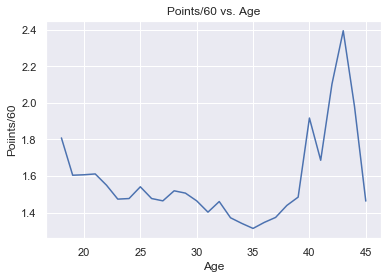

In [316]:
fig = sns.lineplot(x='age_start', y='points_60', data=age_df)
plt.xlabel('Age')
plt.ylabel('Poiints/60')
plt.title('Points/60 vs. Age')
plt.show(fig)

There's a couple things to note here. First is that spike at the end. You certainly wouldn't expect a player to perform better in their later 30's and early 40's, so what gives? The sample size of players at those higher ages will be much smaller, and those players tend to be very talented players, they have to be to be able to stick around in a league that's getting younger by the year. While they're less talented/robust peers of their age are already on the golf course, they manage to stick around doing what they love for a little bit longer. In the upper 30's you'll see people like Joe Thornton and Joramir Jagr who are, though not quite what they used to be, still more productive than the average NHL player of any age. The spike over 40 in particular, is soley Jagr. The man is a freak of nature, and despite being almost 48 (as of January 2020) is still playing pro hockey in the Czech Repulbic. 

We have a similar issue with the perplexing downward trend at the earlier ages. It takes a really talented player to break into the leage at or around 20 years of age. The sample size of players at the age is not representative of the sample of players in their late 20's. Thus, as more average players enter the league once they've earned their salt, they bring down the average offensive production for that age group. Additionally, as a player matures and begins to develope more ice time, there's a greater chance it's going to be against higher competition. Points/60 alone sometimes might favor a younger player playing sheletered minutes against weaker competition in their earlier years.

All of this isn't necessarily fact, and digging into it further is beyond the scope of this project, but is merely my thoughts when looking at the chart above

Let's take a look at the players with the top 100 points per 60 minutes and how they perform with age. Focusing on a more homogenous group should shed some more light on the matter

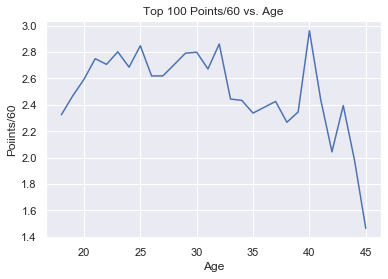

In [317]:
fig = sns.lineplot(x='age_start', y='points_60', data=age2_df)
plt.xlabel('Age')
plt.ylabel('Poiints/60')
plt.title('Top 100 Points/60 vs. Age')
plt.show(fig)

This shape is more in line with what I had in mind. We see a bit of a climb in the early 20's, a peak in the mid-late, and a drop after 30. Once again, you can ignore the spike at 40 from Jagr. He doesn't count. The man is a unit.

A couple things to note here. It should go without saying that points per 60 is far from the only statistic of worth. Defensive responsibility is regarded as a much more difficult thing than offense for a player to learn as he enters the league. A player in his late 20's should earn more ice time as he hones his defensive game and his total point production (not per 60) could very possibly see a bigger jump than his points per 60 as a result.

Another thing to note is the presense of survirship bias. The stats you see for people into their mid 30's have been blessed with better longevity than their peers. Take for example two players, Player A and Player B, who produced at a similar level in their mid-late twenties. At age 33, Player A is still kicking, he has a killer fitness regime and has the genetics to boot. Player B saw a huge drop in production, saw dimished ice time, and subsequently retired at 34. Player A is still playing the next season, and Player B's stats are no longer present in the data. 

Once again these aren't necessarily facts, just my thoughts on the matter. But this will at least give you a general idea as to where a players' rise and dropoff might occur.

### Looking into Advanced Stats

"Advanced stats" have been quite the buzzword(s) in the hockey world the past several years. There's been growing support for utilizing stats that go beyond the simple goals, assists, points, and the general "eye test". The idea here is that a player might add value in a way that might be overlooked by the eye test and simple statistics alone.

Three of the most popular ones are Corsi, Fenwick, and Expected Goals. You can refer to the link below, which gives a very helpful summary of the three. I'll also summarize below.

https://www.hockey-reference.com/about/advanced_stats.html


**Corsi:**

This is an attempted shots differential, which includes both missed and shots blocked. The idea here is get a sense of how much a player drives possession, and figures that which team tends to shoot the puck more when this player is on the ice is a good proxy for overall possession. I'll calculate Corsi %, which is defined as (Corsi for)/(Corsi for + Corsi against).

**Fenwick:**

This is the exact same thing as Corsi but excludes blocked shots. Consider using Fenwick if you're of the mindset that a blocked shot is not indicative of good puck possession.

**Expected Goals:**

Corsi and Fenwick consider the amount of shots a player is on the ice for, but doesn't consider the quality of those shots. Expected Goals attempts to remedy this by considering shot quality, it gives more weight to a more dangerous shot than say a weak wrist shot from the point. In other words, Expected Goals For will tell you how many goals a player is expected to get based on the amount of shots they took and considers league-wide averages in determining the likelihood each of those shots are going to results in a goal.

Creating Corsi and Fenwick % stats

In [318]:
df['Cperc'] = df['CF']/(df['CF'] + df['CA'])
df['Fperc'] = df['FF']/(df['FF'] + df['FA'])

**Being what some call an "Advanced Stat Darling" is great and all. But no matter which way you cut it, if you want make the big bucks you've got to produce. Before we see how these stats correlate with salary, let's take a look at how they relate to some standard stats.**

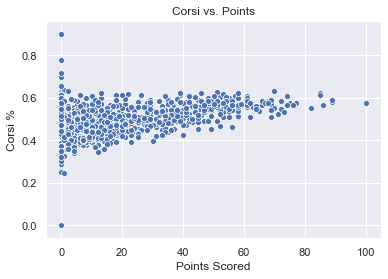

In [319]:
fig = sns.scatterplot(x = 'PTS', y = 'Cperc', data = df)
plt.xlabel('Points Scored')
plt.ylabel('Corsi %')
plt.title('Corsi vs. Points')
plt.show(fig)

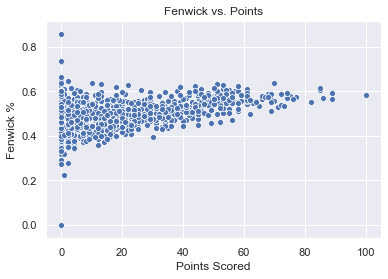

In [320]:
fig = sns.scatterplot(x = 'PTS', y = 'Fperc', data = df)
plt.xlabel('Points Scored')
plt.ylabel('Fenwick %')
plt.title('Fenwick vs. Points')
plt.show(fig)

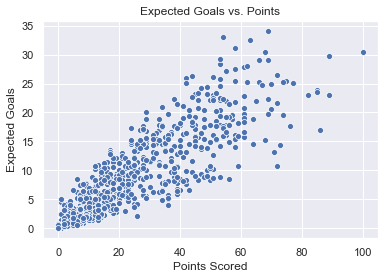

In [321]:
fig = sns.scatterplot(x = 'PTS', y = 'ixG', data = df)
plt.xlabel('Points Scored')
plt.ylabel('Expected Goals')
plt.title('Expected Goals vs. Points')
plt.show(fig)

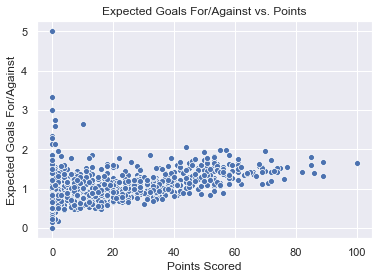

In [322]:
fig = sns.scatterplot(x = 'PTS', y = df['xGF']/df['xGA'], data = df)
plt.xlabel('Points Scored')
plt.ylabel('Expected Goals For/Against')
plt.title('Expected Goals For/Against vs. Points')
plt.show(fig)

The top two look pretty darn similar, and show a clear positive correlation. The Expected Goals vs. Points chart shows a good deal of differentiation.

### Advanced Stats vs. Salary

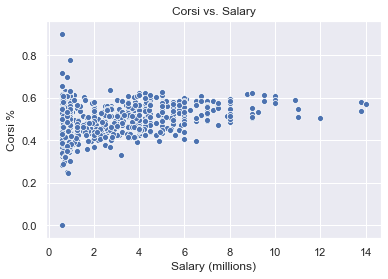

In [323]:
fig = sns.scatterplot(x = df['Salary']/1000000, y = 'Cperc', data = df)
plt.xlabel('Salary (millions)')
plt.ylabel('Corsi %')
plt.title('Corsi vs. Salary')
plt.show(fig)

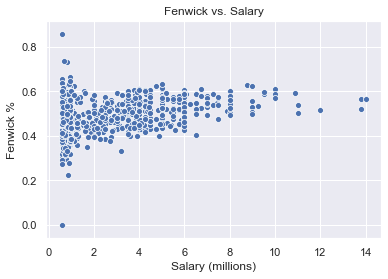

In [324]:
fig = sns.scatterplot(x = df['Salary']/1000000, y = 'Fperc', data = df)
plt.xlabel('Salary (millions)')
plt.ylabel('Fenwick %')
plt.title('Fenwick vs. Salary')
plt.show(fig)

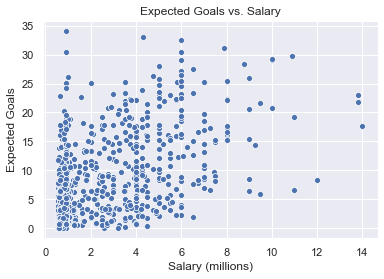

In [325]:
fig = sns.scatterplot(x = df['Salary']/1000000, y = 'ixG', data = df)
plt.xlabel('Salary (millions)')
plt.ylabel('Expected Goals')
plt.title('Expected Goals vs. Salary')
plt.show(fig)

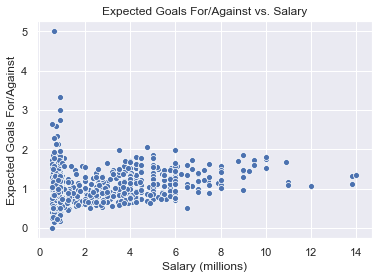

In [326]:
fig = sns.scatterplot(x = df['Salary']/1000000, y = df['xGF']/df['xGA'], data = df)
plt.xlabel('Salary (millions)')
plt.ylabel('Expected Goals For/Against')
plt.title('Expected Goals For/Against vs. Salary')
plt.show(fig)

With the exception of Expected Goals, we can see a pretty clear correlation between these stats and salary. Once again though, I'm a little concerned that the column of entry level contracts might distort the models results and hurt it's predictive value. This seems to be more of an issue with the first two, as expected goals is a little more all over the place.

Advanced stats are just part of the picture. People are getting more on board with the insight they can provide a team. But like anything fancy and new, it has it's fair share of skeptics. There are plenty out there who believe the stats are over-hyped and still rely, for better or worse, on their old-school methods of player evaluation. I'd say most people lie somewhere in between, in that that these stats certainly add value and are worth strong consideration but are far from a fix-all solution.

Now that we've looked at what might be some of the more important factors driving a player's salary, let's get to building a neural network.

# Building the Neural Network

## Prep Work

First I'm going to first scale the target variable.

In [327]:
sal_min = df['Salary'].min()
sal_max = df['Salary'].max()
df['Salary_scaled'] = (df['Salary'] - sal_min) / (sal_max - sal_min)

### Train Test Split

In [328]:
drop_cols2.extend(['birthDate', 'DftRd', 'DftYr', 'Ovrl', 'Salary', 'player_id'])

In [329]:
train0, test0 = train_test_split(df, test_size=0.2)
train0, val0 = train_test_split(train0, test_size=0.25)
print(len(train0), 'train examples')
print(len(val0), 'validation examples')
print(len(test0), 'test examples')

525 train examples
175 validation examples
175 test examples


In [330]:
test = test0.copy()
train = train0.copy()
val = val0.copy()

In [331]:
df.drop(drop_cols2, axis = 1, inplace = True)
test.drop(drop_cols2, axis = 1, inplace = True)
train.drop(drop_cols2, axis = 1, inplace = True)
val.drop(drop_cols2, axis = 1, inplace = True)

### Input Pipeline

In [332]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Salary_scaled')
#     print(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [333]:
batch_size = 50
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [334]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of Goals:', feature_batch['G'])
    print('A batch of targets:', label_batch )

Every feature: ['Nat', 'Ht', 'Wt', 'Hand', 'GP', 'G', 'A', 'A1', 'A2', 'PTS', 'plsmin', 'Eplsmin', 'PIM', 'Shifts', 'TOI', 'TOIX', 'TOIGP', 'TOIGP1', 'TOIperc', 'IPPperc', 'SHperc', 'SVperc', 'PDO', 'F60', 'A60', 'Pctperc', 'Diff', 'Diff60', 'iCF', 'iCF1', 'iFF', 'iSF', 'iSF1', 'iSF2', 'ixG', 'iSCF', 'iRB', 'iRS', 'iDS', 'sDist', 'Pass', 'iHF', 'iHF1', 'iHA', 'iHDf', 'iMiss', 'iGVA', 'iTKA', 'iBLK', 'iGVA1', 'iTKA1', 'iBLK1', 'BLKperc', 'iFOW', 'iFOL', 'iFOW1', 'iFOL1', 'FOperc', 'percFOT', 'dzFOW', 'dzFOL', 'nzFOW', 'nzFOL', 'ozFOW', 'ozFOL', 'FOWUp', 'FOLUp', 'FOWDown', 'FOLDown', 'FOWClose', 'FOLClose', 'OTG', '1G', 'GWG', 'ENG', 'PSG', 'PSA', 'GBkhd', 'GDflct', 'GSlap', 'GSnap', 'GTip', 'GWrap', 'GWrst', 'CBar', 'Post', 'Over', 'Wide', 'SBkhd', 'SDflct', 'SSlap', 'SSnap', 'STip', 'SWrap', 'SWrst', 'iPenT', 'iPenD', 'iPENT', 'iPEND', 'iPenDf', 'NPD', 'Min', 'Maj', 'Match', 'Misc', 'Game', 'CF', 'CA', 'FF', 'FA', 'SF', 'SA', 'xGF', 'xGA', 'SCF', 'SCA', 'GF', 'GA', 'RBF', 'RBA', 'RSF'

### Feature Columns

**Feature Lists**

In [335]:
cat_feat = ['Nat', 'Hand']
# cat_feat = ['Nat', 'Hand', 'DftYr', 'DftRd', 'Ovrl']
# rem_feat.append('Salary')
rem_feat = ['Nat', 'Hand', 'Salary_scaled']
# num_feat = ['G']
num_feat = list(df.drop(rem_feat, axis=1).columns)

**Scalar Function**

In [336]:
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
    return(minmax)

**Numerical Features**

In [337]:
feature_columns = []
for header in num_feat:
    scal_input_fn = get_scal(header)
    feature_columns.append(feature_column.numeric_column(header, normalizer_fn=scal_input_fn))

**Categorical Features**

In [338]:
for feature_name in cat_feat:
    vocabulary = train_df[feature_name].unique()
    cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = feature_column.indicator_column(cat_c)
    feature_columns.append(one_hot)

## Creating the Model

**Creating the Layers**

In [339]:
# First create the feature layer
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,  
  layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
#   layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu'),
  layers.Dropout(0.2),
  
  layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse']
             )

**Fitting the Model**

In [340]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
11/11 [==============================] - 13s 1s/step - loss: 0.5529 - mse: 0.0340 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 1s 48ms/step - loss: 0.4884 - mse: 0.0272 - val_loss: 0.4436 - val_mse: 0.0155
Epoch 3/100
11/11 [==============================] - 1s 49ms/step - loss: 0.4275 - mse: 0.0226 - val_loss: 0.3896 - val_mse: 0.0145
Epoch 4/100
11/11 [==============================] - 1s 48ms/step - loss: 0.3746 - mse: 0.0198 - val_loss

## Evaluation

### Train vs Val "mse" and "loss"

In [341]:
loss, mse = model.evaluate(test_ds)
print("Mean Squared Error: ", mse * ((sal_max - sal_min) + sal_min))

4/4 [==============================] - 0s 22ms/step - loss: 0.0085 - mse: 0.0043
Mean Squared Error:  60592.872090637684


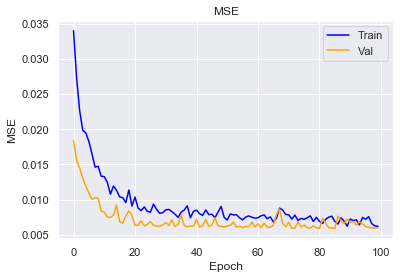

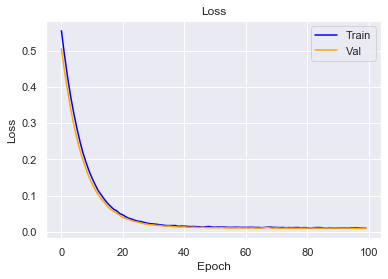

In [342]:
epochs = range(100)

plt.title('MSE')
plt.plot(epochs,  history.history['mse'], color='blue', label='Train')
plt.plot(epochs, history.history['val_mse'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

_ = plt.figure()
plt.title('Loss')
plt.plot(epochs, history.history['loss'], color='blue', label='Train')
plt.plot(epochs, history.history['val_loss'], color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

It looks like after 20 or so epochs we're past the elbow and start experiencing diminishing returns.

### Test Data

**I'm going to need to descale the target variable**

In [343]:
pred_salary_scaled = model.predict(test_ds)
pred_salary = pred_salary_scaled * ((sal_max - sal_min) + sal_min)

In [344]:
test0['Pred_Salary'] = pred_salary

# Remove scientific notation
test0['Pred_Salary'] = test0['Pred_Salary'].round()

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**Mean Sqare Error**

In [345]:
MSE = (((test0['Salary'] - test0['Pred_Salary']) ** 2).mean() ** .5)
MSE

961882.0916940673

This isn't too bad. Not great, but definitely acceptable when trying to get a ballpark range for a player.

**Here I'm going to sort the players by the absolute value of the actual and predicted salaries to see who are the most over and under-paid players in the league.**

It looks like the model doesn't perform terribly well for players making under \\$1m. Part of it is the model does not consider there is a league-minimum salary of \$650k. Another aspect, which I outlined earlier, are the players on ELCs that are drastically outperforming the maximum ELC salary of \\$925k. I'll ignore these players below for these reasons.

In [346]:
# Create difference and absolute difference columns
test0['Diff'] = test0['Salary'] - test0['Pred_Salary']
test0['Abs_Diff'] = test0['Diff'].abs()
test0['xGperc'] = test0['xGF'] / test0['xGA']


test_new = test0.loc[(test0['Salary'] > 1000000),
        ['Salary', 'Pred_Salary', 'Diff', 'Abs_Diff', 'last_first', 
       'Position', 'GP', 'PTS', 'G', 'A', 'Cperc', 'Fperc', 'xGperc']].sort_values(by=['Abs_Diff'], ascending=False)

test_new.head(n=10)

C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,Salary,Pred_Salary,Diff,Abs_Diff,last_first,Position,GP,PTS,G,A,Cperc,Fperc,xGperc
625,5750000.0,2185101.0,3564899.0,3564899.0,Radulov_Alex,[RW],76,54,18,36,0.584884,0.578370,1.472222
354,1750000.0,4418158.0,-2668158.0,2668158.0,Vermette_Antoine,"[C, LW]",72,28,9,19,0.508388,0.507094,1.099391
874,7000000.0,4408276.0,2591724.0,2591724.0,Ryan_Bobby,"[RW, LW]",62,25,13,12,0.557022,0.549234,1.200557
723,4900000.0,2476713.0,2423287.0,2423287.0,Methot_Marc,[D],68,12,0,12,0.439716,0.451509,0.831731
564,6500000.0,4139618.0,2360382.0,2360382.0,Callahan_Ryan,[RW],18,4,2,2,0.395918,0.405405,0.509934
167,5000000.0,2807954.0,2192046.0,2192046.0,Vatanen_Sami,[D],71,24,3,21,0.513777,0.516764,1.248580
621,4500000.0,2386037.0,2113963.0,2113963.0,MacArthur_Clarke,[LW],4,0,0,0,0.614583,0.605634,1.764706
777,2200000.0,342580.0,1857420.0,1857420.0,Bouma_Lance,"[C, LW, RW]",61,7,3,4,0.399107,0.414541,0.572414
411,2500000.0,4344334.0,-1844334.0,1844334.0,Hainsey_Ron,[D],72,17,4,13,0.457278,0.451526,0.868773
527,4000000.0,2185839.0,1814161.0,1814161.0,Brodin_Jonas,[D],68,25,3,22,0.495495,0.499144,1.134043


**Some thoughts on the model and it's possible uses:**

At this point I don't really envision this model being used to decide how much to pay a player or to provide any sort of validation. It wouldn't exactly provide a lot of leverage in the negotiation process or anything.

I do feel, however, that this model could be of value when searching for under-paid players. It could help flag great-value players that might be otherwise overlooked. I'm going to take a look at some players that are seemingly under-paid and try to see what might be driving that. 

In [347]:
# test_new
under_paid = test_new[test_new['Diff'] < 0]
under_paid.head(n = 15)

,Salary,Pred_Salary,Diff,Abs_Diff,last_first,Position,GP,PTS,G,A,Cperc,Fperc,xGperc
354,1750000.0,4418158.0,-2668158.0,2668158.0,Vermette_Antoine,"[C, LW]",72,28,9,19,0.508388,0.507094,1.099391
411,2500000.0,4344334.0,-1844334.0,1844334.0,Hainsey_Ron,[D],72,17,4,13,0.457278,0.451526,0.868773
451,4300000.0,5667494.0,-1367494.0,1367494.0,Simmonds_Wayne,"[RW, LW]",82,54,31,23,0.578016,0.588235,1.634228
238,5000000.0,6169974.0,-1169974.0,1169974.0,McDonagh_Ryan,[D],77,42,6,36,0.495199,0.515118,1.209716
800,2500000.0,3667226.0,-1167226.0,1167226.0,Trouba_Jacob,[D],60,33,8,25,0.474071,0.481265,0.957865
604,3700000.0,4688498.0,-988498.0,988498.0,Bailey_Josh,"[RW, LW, C]",82,56,13,43,0.551006,0.559480,1.359551
216,5400000.0,6229366.0,-829366.0,829366.0,Koivu_Mikko,[C],80,58,18,40,0.506864,0.511660,1.365685
125,3000000.0,3794879.0,-794879.0,794879.0,Ekholm_Mattias,[D],82,23,3,20,0.503744,0.497917,0.990172
80,2750000.0,3507131.0,-757131.0,757131.0,Tatar_Tomas,"[LW, C, RW]",82,46,25,21,0.563272,0.552573,1.318359
352,1250000.0,1930038.0,-680038.0,680038.0,Fiddler_Vernon,"[C, LW]",59,4,2,2,0.348958,0.358796,0.451524


*Just a note, Thomas Vanek's stats seem to be wrong. I'm not sure why. I spot chekced several others and they looked OK. So we can ignore him for the purpose of this project, but it certainly raises a question as to the quality of the rest of the data.*

In a lot of these cases, it's not a secret that the contract is a good deal. If, however it's a more subtle quality, you can hopefully obtain the player in a trade for a bargain. It always behooves a team to try have an informational advantage over it's competitors.

The stats I brought in aren't obscure by any means, but it serves to illustrate the methodology that one may can employ when evaluating contracts around the NHL.

# Concluding Remarks

As is always the case, most of the time required to set up this model was spent on the EDA process. The cleaning for DB1 alone was pretty short and manageable. I dropped some columns, renamed some others, created a field or two, and and parsed/pivoted the "Position" field. I planned on bringing in additional data in order to bring in longer-term statistics, but the unreliability of the birthdays in DB1 made that a necessity.

Bringing in data from two different data sources is a great way to give yourself a ton of extra cleaning to do, since odds are you won't have a perfect primary/foreign key setup. In addition, I had to deal with players that didn't exist in DB2. This impacted what features I did bring into DB1, as I wasnted to ensure it would be easy to find data that already existed in DB1 as a suitable replacement for the DB2 data brought in.

We then explored the data through some visualizations to illustrate the correlation some variables, such as Goals, Assists, Corsi, and Fenwick had both with each other and the Target Variable - Salary.

Then after a little prep work, we had ended up with a model that gives you a ball-park range of what a player should be making. It didn't perform too well for Entry-Level contracts, so I ended up ignoring those. I didn't exactly have this in mind going into the project, but it was at this point I realized that the best use for this model was probably with regard to the discovery of value-contracts. I don't think it would provide a ton of leverage (unless a lot of work was done to improve the model) in the salary negotiation process. I do think it could be useful when trying to find players outperforming their contract, perhaps and hopefully in ways that are flying under the radar to provide a team with an informational advantage over their peers.

In general, the purpose of this project was to showcase the skills and methodologies involved in obtaining, cleaning, and structuring a dataset for use in a Tensorflow neural network as opposed to the performance of the model itself. In the future I'd like to explore ways to improve the model. This could be a matter of feature engineering, tuning the parameters of the model and so on. All in all, I hope you learned a thing or two about a thing or two. Thanks for reading, and Let's Go Rangers!

# End